# HW05: Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import numba
import pandas as pd
from numba import jit, float64
from sklearn.datasets import make_blobs
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


**Functions to optimize**

In [6]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

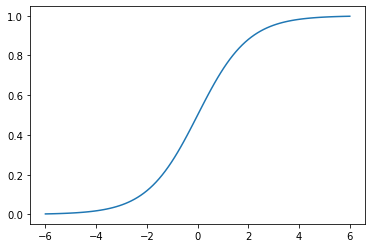

In [7]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [8]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

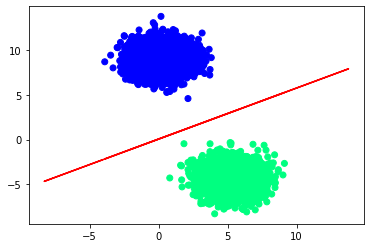

In [9]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [10]:
# Define function
def logistic2(x):
    """Logistic function with only one np.exp call"""
    return 1 / (1 + np.exp(-x))

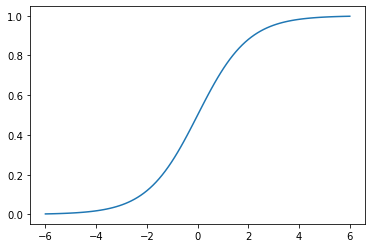

In [11]:
# Show that new function produces same logistic plot
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic2(x))
pass

In [12]:
# Given quantities
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [13]:
# Check more rigorously for agreement between original and newly defined function
res0 = logistic(x)
res1 = logistic2(x)
np.testing.assert_array_almost_equal(res0, res1)

In [14]:
%%timeit
logistic(x)

3.48 s ± 666 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
logistic2(x)

5.84 s ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

*First, we define the two functions described in the first bullet of the exercise*

In [16]:
@numba.vectorize([float64(float64)])
def logistic_numba_cpu(x):
    """Vectorized numba logistic function"""
    return 1 / (1 + np.exp(-x))

In [17]:
@numba.vectorize([float64(float64)],
                target = "parallel")
def logistic_numba_parallel(x):
    """Vectorized, parallel numba logistic function"""
    return 1 / (1 + np.exp(-x))

*Next, we test that all three logistic functions defined so far (excluding the original one provided) produce the same results*

In [18]:
# Calculate output from all 3 logistic functions
res1 = logistic2(x)
res2 = logistic_numba_cpu(x)
res3 = logistic_numba_parallel(x)

# Run pairwise comparisons
np.testing.assert_array_almost_equal(res0, res2)
np.testing.assert_array_almost_equal(res0, res3)
np.testing.assert_array_almost_equal(res1, res2)
np.testing.assert_array_almost_equal(res1, res3)
np.testing.assert_array_almost_equal(res2, res3)

*Since the `np.testing.assert_array_almost_equal()` function does not raise an error for every pairwise combination of outcomes, we can be confident that the function outputs are the same*

*We are also interesting in timing these three logistic functions*

In [19]:
# Initialize dataframe
df = pd.DataFrame(dict(Seconds = [0, 0, 0, 0]), \
                  index = ["Original", "One exp call", "Numba CPU", "Numba Parallel"])

# Calculate run times
original = %timeit -o logistic(x)
one_exp_call = %timeit -o logistic2(x)
cpu = %timeit -o logistic_numba_cpu(x)
parallel = %timeit -o logistic_numba_parallel(x)

# Fill in dataframe, and display
df.iloc[0, 0] = original.average
df.iloc[1, 0] = one_exp_call.average
df.iloc[2, 0] = cpu.average
df.iloc[3, 0] = parallel.average
df

4.02 s ± 53.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.96 s ± 1.35 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.95 s ± 44.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
177 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,Seconds
Original,4.021895
One exp call,4.955345
Numba CPU,1.953736
Numba Parallel,0.177169


*Next, we create logistic and gradient descent functions using jit. We'll ensure that the results of these functions match the results that we've seen previously, and we'll time the new gradient descent function (relative to the original)*

In [20]:
@jit('double[:](double[:])', nopython = True, cache = True)
def logistic_numba(x):
    """Logistic function with jit"""
    return 1 / (1 + np.exp(-x))

In [21]:
# Test logistic_numba
res4 = logistic_numba(x)
np.testing.assert_array_almost_equal(res0, res4)

*The new logistic function (with numba) appears to agree in result with the previous versions of the logistic function*

In [22]:
@jit('double[:](double[:,:], double[:], double[:], double, double)', nopython = True, cache = True)
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm with jit"""
    
    # Define constants, and initialize vectors
    n, p = X.shape
    Xt = X.T
    y_pred = np.zeros(n)
    x_beta = np.zeros(n)
    epsilon = np.zeros(n)
    grad = np.zeros(p)

    # Perform iterations using for loops to leverage C's strengths
    for q in range(niter):
        # Calculate vector of predicted y values
        for i in range(n):
            x_beta[i] = 0
            for j in range(p):
                x_beta[i] += X[i, j] * beta[j]
        y_pred = logistic_numba(x_beta)
        # Calculate epsilon
        for k in range(n):
            epsilon[k] = y[k] - y_pred[k]
        # Calculate gradient and updated value of beta
        for l in range(p):
            grad[l] = 0
            for m in range(n):
                grad[l] += Xt[l, m] * epsilon[m] / n
            beta[l] += alpha * grad[l]
    
    return beta

In [23]:
# Test different gradient descent functions
β1 = gd(X, y, β, α, niter)
β2 = gd_numba(X, y, β, α, niter)

# Check for equality
np.testing.assert_array_almost_equal(β1, β2)

*The two gradient descent functions appear to agree in result*

In [24]:
%%timeit
gd(X, y, β, α, niter)

1.27 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
gd_numba(X, y, β, α, niter)

446 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


*We see that the numba version of the gradient descent function takes about 35% as long to run for the given X, y, $\beta, \alpha$, and niter values given in the introduction to the assignment*

**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

*First, we cythonize the logistic function and compare accuracy / performance*

In [26]:
%%cython

import cython
import numpy as np
from libc.math cimport exp

@cython.cdivision
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef logistic_cython(double[:] x, double[:] res):
    """Cython logistic function"""
    
    # Define constant for iteration in for loop
    cdef int i
    
    # Loop through elements of x
    for i in range(x.shape[0]):
        res[i] = 1 / (1 + exp(-x[i]))
    
    # Return result
    return res

In [27]:
# Compare accuracy
res5 = np.zeros(shape = x.shape[0])
logistic_cython(x, res5)
np.testing.assert_array_almost_equal(res0, res5)

*The new logistic function (with Cython) appears to agree in result with the previous versions of the logistic function*

*Next, we compare performance of the Cython logistic function and see that it is comparable to the version in which we used jit

In [28]:
# Initialize new dataframe rows for jit and cython versions of logistic function
df2 = pd.DataFrame(dict(Seconds = [0, 0]), index = ["JIT", "Cython"])

# Calculate run times
jit = %timeit -o logistic_numba(x)
cython = %timeit -o logistic_cython(x, np.zeros(shape = x.shape[0]))

# Fill in dataframe
df2.iloc[0, 0] = jit.average
df2.iloc[1, 0] = cython.average

# Append df2 to df, and display
df2 = df.append(df2)
df2

286 ms ± 25.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
282 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Seconds
Original,4.021895
One exp call,4.955345
Numba CPU,1.953736
Numba Parallel,0.177169
JIT,0.286005
Cython,0.281727


*Next, we cythonize the gradient descent function*

In [29]:
%%cython

import cython
import numpy as np
from libc.math cimport exp

@cython.cdivision
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef logistic_cython(double[:] x):
    """Cython logistic function"""
    
    # Define constant for iteration in for loop
    cdef int i
    cdef int length = x.shape[0]
    cdef double[:] res = np.zeros(x.shape[0])
    
    # Loop through elements of x
    for i in range(length):
        res[i] = 1 / (1 + exp(-x[i]))
    
    # Return result
    return res

def gd_cython(double[:,:] X, double[:] y, double[:] beta, double[:] res, float alpha, int niter):
    """Gradient descent algorithm with Cython"""
    
    cdef int n = X.shape[0]
    cdef int p = X.shape[1]
    cdef int i, j, k, l, m, q
    cdef double[:] x_beta = np.zeros(n)
    cdef double[:] y_pred
    cdef double[:] epsilon = np.zeros(n)
    cdef double[:,:] Xt = X.T
    cdef double[:] grad = np.zeros(p)
    res = beta
    
    for q in range(niter):
        
        # Calculate vector of predicted y values
        for i in range(n):
            x_beta[i] = 0
            for j in range(p):
                x_beta[i] += X[i, j] * res[j]
        y_pred = logistic_cython(x_beta)
        
        # Calculate epsilon
        for k in range(n):
            epsilon[k] = y[k] - y_pred[k]
        
        # Calculate gradient and updated value of beta
        for l in range(p):
            grad[l] = 0
            for m in range(n):
                grad[l] += Xt[l, m] * epsilon[m] / n
            res[l] += alpha * grad[l]
    
    return res

In [30]:
# Compare accuracy
β1 = gd(X = X, y = y, beta = β, alpha = α, niter = niter)
β3 = np.asarray(gd_cython(X = X, y = y, beta = β, res = np.zeros(X.shape[1]), alpha = α, niter = niter))
np.testing.assert_array_almost_equal(β1, β3)

*The new gradient descent function (with Cython) appears to agree in result with the previous versions of the gradient descent functions*

*We also see that gd_cython is slightly slower than gd_numba and much faster than the original gradient descent function*

In [31]:
df_gd = pd.DataFrame(dict(Seconds = [0, 0, 0]), index = ["Standard", "Numba", "Cython"])

# Calculate run times
standard = %timeit -o gd(X, y, β, α, niter)
numba = %timeit -o gd_numba(X, y, β, α, niter)
cython = %timeit -o gd_cython(X = X, y = y, beta = β, res = np.zeros(X.shape[1]), alpha = α, niter = niter)

# Fill in dataframe
df_gd.iloc[0, 0] = standard.average
df_gd.iloc[1, 0] = numba.average
df_gd.iloc[2, 0] = cython.average

# Display result
df_gd

1.17 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
449 ms ± 4.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
502 ms ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Seconds
Standard,1.170152
Numba,0.449328
Cython,0.502325


**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

*First, we make sure that we have access to the eigen library*

In [32]:
import os
if not os.path.exists('./eigen'):
    ! git clone https://gitlab.com/libeigen/eigen.git

*Next, we'll write the logistic function in C++, compare accuracy, and compare performance*

In [33]:
%%file hw_cpp.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['./eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

namespace py = pybind11;
using namespace Eigen;

VectorXd logistic_cpp(VectorXd x){
    return 1 / (1 + exp((-x).array()));
}

PYBIND11_MODULE(hw_cpp, m) {
    m.def("logistic_cpp", &logistic_cpp);
}

Writing hw_cpp.cpp


In [34]:
import cppimport
code = cppimport.imp("hw_cpp")

In [35]:
# Compare accuracy
res6 = code.logistic_cpp(x)
np.testing.assert_array_almost_equal(res0, res6)

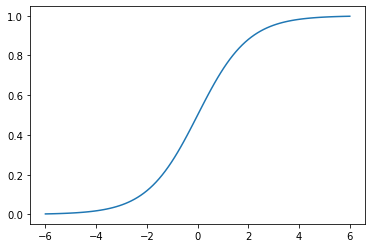

In [36]:
# Generate logistic plot using C++ version of function
x2 = np.linspace(-6, 6, 100)
plt.plot(x2, code.logistic_cpp(x2))
pass

In [37]:
# Compare performance
df3 = pd.DataFrame(dict(Seconds = [0]), index = ["C++"])
cpp = %timeit -o code.logistic_cpp(x)
df3.iloc[0, 0] = cpp.average
df2.append(df3)

233 ms ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Seconds
Original,4.021895
One exp call,4.955345
Numba CPU,1.953736
Numba Parallel,0.177169
JIT,0.286005
Cython,0.281727
C++,0.232568


*It looks like our implementation of the logistic function in C++ is the fastest serial version of all of the methods attempted*

*Now, we shift to the gradient descent function in C++. After programming the function, we'll start by checking accuracy and performance*

In [38]:
%%file hw_cpp2.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['./eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

namespace py = pybind11;
using namespace Eigen;

// Define logistic function
VectorXd logistic_cpp(VectorXd x){
    return 1 / (1 + exp((-x).array()));
}

// Define gradient descent function
VectorXd gd_cpp(MatrixXd X, VectorXd y, VectorXd beta, double alpha, int niter) {
    
    // Define variables
    int n = X.rows();
    int p = X.cols();
    MatrixXd Xt = X.transpose();
    VectorXd y_pred = VectorXd::Zero(n);
    VectorXd epsilon = VectorXd::Zero(n);
    VectorXd grad = VectorXd::Zero(p);
    
    // Loop through specified number of iterations
    for (int i = 0; i < niter; i++) {
        y_pred = logistic_cpp(X * beta);
        epsilon = y - y_pred;
        grad = Xt * epsilon / n;
        beta += alpha * grad;
    }
    return beta;
}

PYBIND11_MODULE(hw_cpp2, m) {
    m.def("logistic_cpp", &logistic_cpp);
    m.def("gd_cpp", &gd_cpp);
}

Writing hw_cpp2.cpp


In [39]:
import cppimport
code = cppimport.imp("hw_cpp2")

In [40]:
# Compare accuracy
β4 = code.gd_cpp(X, y, β, α, niter)
β1 = gd(X, y, β, α, niter)
np.testing.assert_array_almost_equal(β1, β4)

In [41]:
df_gd2 = pd.DataFrame(dict(Seconds = [0]), index = ["C++"])
cpp = %timeit -o code.gd_cpp(X, y, β, α, niter)
df_gd2.iloc[0, 0] = cpp.average
df_gd.append(df_gd2)

174 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


,Seconds
Standard,1.170152
Numba,0.449328
Cython,0.502325
C++,0.174266


*We see that our gradient descent fucnction coded in C++ is much faster than all other versions of the gradient descent function that we have considered in this assignment*

*Lastly, we will recreate the other plot (with the two clusters) from the introduction to the assignment, using the C++ wrapped functions*

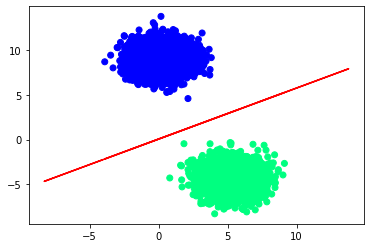

In [42]:
# Initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# Call gradient descent
β = code.gd_cpp(X, y, β, α, niter)

# Assign labels to points based on prediction
y_pred = code.logistic_cpp(X @ β)
labels = y_pred > 0.5

# Calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass